In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import math

In [3]:
import SEACells

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

In [6]:
# Load the data using 
ad = sc.read('data/cd34_multiome_rna.h5ad')

In [7]:
ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype'
    var: 'highly_variable'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [8]:
ls

SEACells/       db.sqlite3      manage.py*      project/        visualization/
data/           docs/           notebook.ipynb  templates/


In [9]:
#ad.obs[['n_counts']].head(20)

/var/folders/4l/kjyt825d7m97k860b19j1kbm0000gn/T/ipykernel_2739/2799641324.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ad.to_df().sum(1))


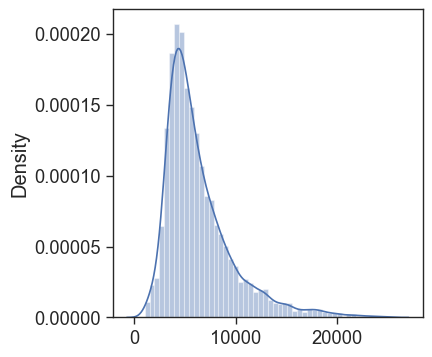

In [10]:
sns.distplot(ad.to_df().sum(1))

In [11]:
ad.obsm['X_umap']

array([[-1.2229071, -0.6132746],
       [ 1.8329703,  3.1520174],
       [-1.0225825, -4.8961134],
       ...,
       [-2.1479514, -5.4740114],
       [-4.033423 , -0.9060846],
       [-1.1667424, -2.3856318]], dtype=float32)

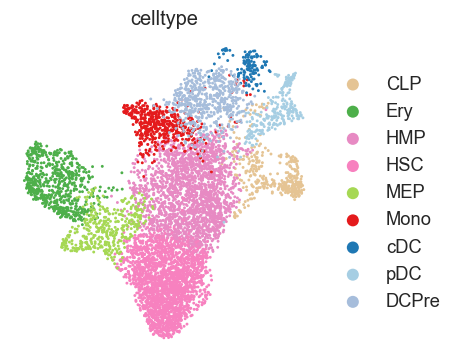

In [12]:
# Plot cell-types for reference
sc.pl.scatter(ad, basis='umap', color='celltype', frameon=False)
# algorithms to construct convex hull

In [13]:
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.X)
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [14]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1500)

In [15]:
ad.layers

Layers with keys: 

In [16]:
# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explained
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)

In [17]:
ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'

In [18]:
## User defined parameters

## Core parameters 
n_SEACells = 90
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [19]:
model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [20]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/6881 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/6881 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/6881 [00:00<?, ?it/s]

Constructing CSR matrix...


/Users/armanozcan/opt/anaconda3/envs/seacells/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


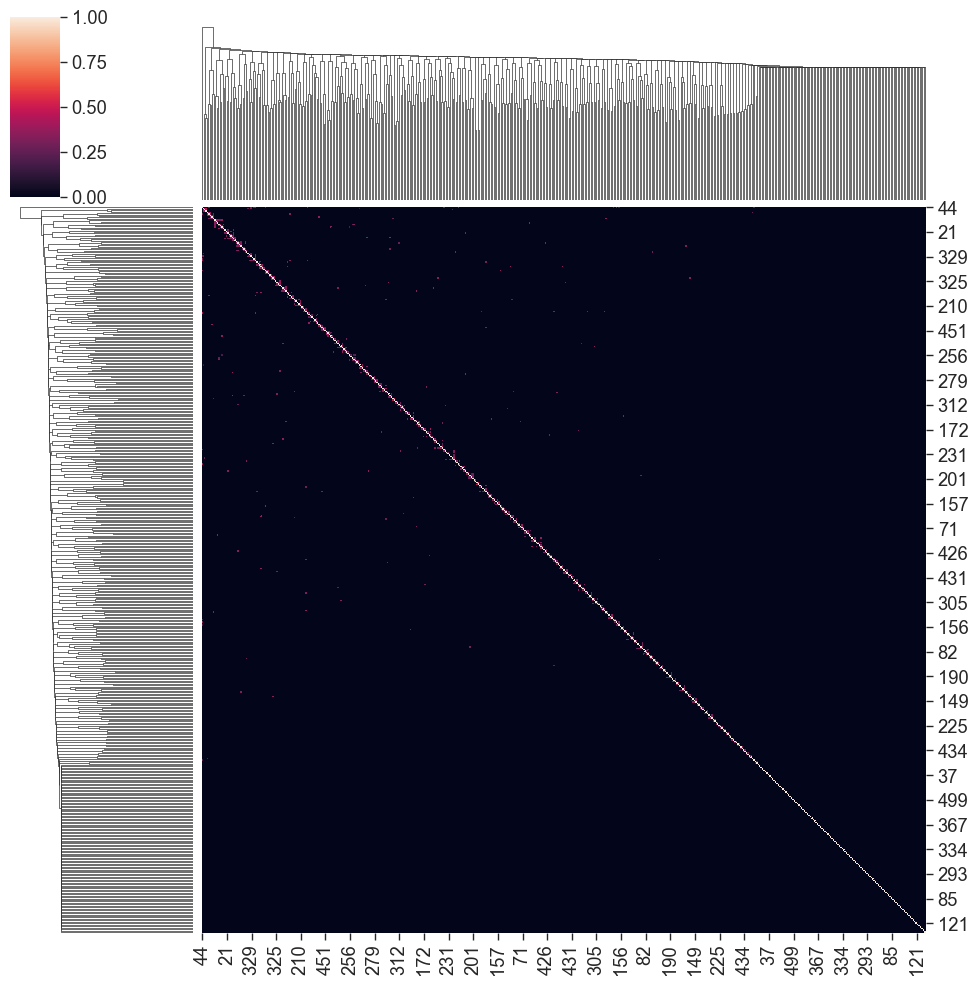

In [21]:
sns.clustermap(M.toarray()[:500,:500])

In [22]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 83 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 112.33it/s]

Selecting 7 cells from greedy initialization.


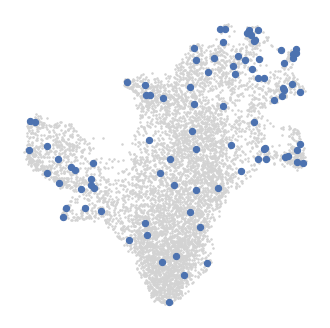

In [23]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(ad, model)

In [24]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00152
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 35 iterations.


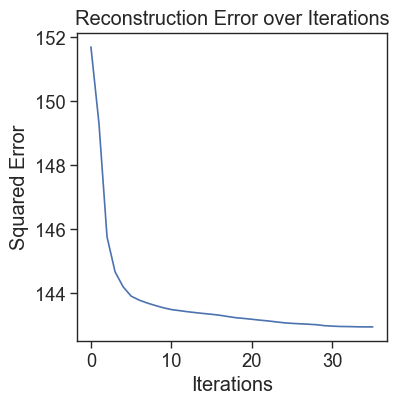

In [25]:
# Check for convergence 
model.plot_convergence()

In [26]:
ad.obs[['SEACell']].head()

,SEACell
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,SEACell-13
cd34_multiome_rep1#AAACAGCCACTGACCG-1,SEACell-18
cd34_multiome_rep1#AAACAGCCATAATCAC-1,SEACell-39
cd34_multiome_rep1#AAACATGCAAATTCGT-1,SEACell-29
cd34_multiome_rep1#AAACATGCAGCATGTC-1,SEACell-40


In [27]:
model.A_.shape
#groupings of seacells

(90, 6881)

/var/folders/4l/kjyt825d7m97k860b19j1kbm0000gn/T/ipykernel_2739/2761727437.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)


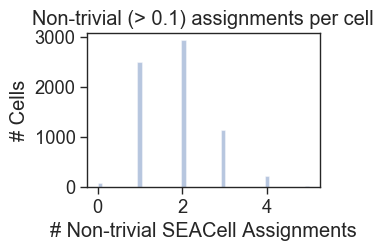

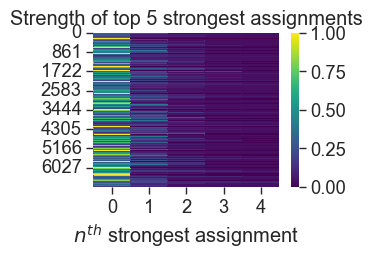

In [28]:
plt.figure(figsize=(3,2))
sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)
plt.title(f'Non-trivial (> 0.1) assignments per cell')
plt.xlabel('# Non-trivial SEACell Assignments')
plt.ylabel('# Cells')
plt.show()

plt.figure(figsize=(3,2))
b = np.partition(model.A_.T, -5)    
sns.heatmap(np.sort(b[:,-5:])[:, ::-1], cmap='viridis', vmin=0)
plt.title('Strength of top 5 strongest assignments')
plt.xlabel('$n^{th}$ strongest assignment')
plt.show()

In [29]:
#print(heapq.nlargest(363, weights.tolist()))

In [30]:
#A = model.A_
#A[A<0.1] = 0
#print(A[np.where((A >0.05) & (A< 0.1))].shape)

In [31]:
np.argmax(np.sum(model.A_, axis= 1))

11

In [32]:
#(np.sum(model.A_, axis=0)) #(all 1's)

In [33]:
sum(model.A_[:,0])

1.0

In [34]:
model.get_hard_assignments().head()

,SEACell
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,SEACell-13
cd34_multiome_rep1#AAACAGCCACTGACCG-1,SEACell-18
cd34_multiome_rep1#AAACAGCCATAATCAC-1,SEACell-39
cd34_multiome_rep1#AAACATGCAAATTCGT-1,SEACell-29
cd34_multiome_rep1#AAACATGCAGCATGTC-1,SEACell-40


In [35]:
labels,weights = model.get_soft_assignments()

In [36]:
labels

,0,1,2,3,4
index,,,,,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#GGGCCTAGTTCTTTAG-1,cd34_multiome_rep2#TTGTCCGGTGAGGTGA-1,cd34_multiome_rep2#GTTAATGTCGTGCTAG-1,cd34_multiome_rep2#CTACCGGCAACCTAAT-1,cd34_multiome_rep2#CAGGACCTCCCTCAAC-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep2#GCTCAACCACCTAATG-1,cd34_multiome_rep2#TTTCCGGGTCCTCCAA-1,cd34_multiome_rep2#GTGGCTTCAAGGTCCT-1,cd34_multiome_rep2#CGAAATGAGTAAGTCC-1,cd34_multiome_rep1#AATCCGTAGCGGTTAT-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep1#TTGTTGTTCATAGCCG-1,cd34_multiome_rep1#TATCACAAGCACGATT-1,cd34_multiome_rep2#GGGCAATAGGTAACGA-1,cd34_multiome_rep1#TAGCTAGGTAGGTTAT-1,cd34_multiome_rep1#AGGTCCGGTAATGGCC-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep1#CCATAGCCATGGCCTG-1,cd34_multiome_rep2#GCCATTACATACCCGG-1,cd34_multiome_rep1#ACATTGCAGACTATTG-1,cd34_multiome_rep1#TTAGTCAAGTGACCTG-1,cd34_multiome_rep2#GCTCAACCACCTAATG-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#TAGGAACCATTCAGCA-1,cd34_multiome_rep2#GCTAGCCAGCCGCTTT-1,cd34_multiome_rep2#TAGGTTATCCGCAACA-1,cd34_multiome_rep2#TGGTCATAGGTAAGGC-1,cd34_multiome_rep1#GACCTAAGTCGCAATA-1
...,...,...,...,...,...
cd34_multiome_rep2#TTTGTCTAGGGCCACT-1,cd34_multiome_rep1#GTGGATGCATCAGTAT-1,cd34_multiome_rep1#GCGCAATGTTTCCACG-1,cd34_multiome_rep1#ATTCCTCCACTAAGCC-1,cd34_multiome_rep1#CTGACATAGCTAAAGG-1,cd34_multiome_rep1#CAGCATGTCTAACTGA-1
cd34_multiome_rep2#TTTGTGAAGGAAGCAC-1,cd34_multiome_rep2#GGGCAATAGGTAACGA-1,cd34_multiome_rep2#AACCGCTCAGCTCAAC-1,cd34_multiome_rep2#ACAGCGCTCACAGGAA-1,cd34_multiome_rep1#TTGTTGTTCATAGCCG-1,cd34_multiome_rep1#TAGCTAGGTAGGTTAT-1
cd34_multiome_rep2#TTTGTGAAGTAACCAC-1,cd34_multiome_rep1#GGACATAAGTTAGAGG-1,cd34_multiome_rep2#ACAGCGCTCACAGGAA-1,cd34_multiome_rep2#GGGCAATAGGTAACGA-1,cd34_multiome_rep2#AATATCCCATAATGTC-1,cd34_multiome_rep2#GTTAGGCGTTACTTGC-1


In [37]:
#print(heapq.nlargest(5, model.A_[:,0]))
sum(model.A_[:,0])
np.argmax(model.A_[:,0])
ind = np.argsort(model.A_[:,0])[::-1][:5]
model.A_[ind,0]
print(model.A_[:,0][model.A_[:,0]>0.025])

[0.48784314 0.03529412 0.03294118 0.02666667 0.14039216 0.02980392
 0.12392157 0.03843137]


In [38]:
np.set_printoptions(suppress=True)
print(weights)
norm_weights = weights
norm_weights[norm_weights<0.05] = 0

[[0.48784314 0.14039216 0.12392157 0.03843137 0.03529412]
 [0.22823529 0.12392157 0.05098039 0.03921569 0.03764706]
 [0.13411765 0.08235294 0.06745098 0.0627451  0.05254902]
 ...
 [0.14980392 0.11137255 0.1027451  0.03921569 0.03764706]
 [1.         0.         0.         0.         0.        ]
 [0.17647059 0.11294118 0.04392157 0.04235294 0.03921569]]


In [39]:
x = np.array([[1,2,3],[4,5,6]])
x.sum(axis=1)
row_sums = norm_weights.sum(axis=1)
new_matrix = norm_weights / row_sums[:, np.newaxis]
print(new_matrix)

[[0.64859228 0.18665276 0.16475495 0.         0.        ]
 [0.56614786 0.307393   0.12645914 0.         0.        ]
 [0.33595285 0.20628684 0.16895874 0.15717092 0.13163065]
 ...
 [0.41163793 0.30603448 0.28232759 0.         0.        ]
 [1.         0.         0.         0.         0.        ]
 [0.6097561  0.3902439  0.         0.         0.        ]]


/var/folders/4l/kjyt825d7m97k860b19j1kbm0000gn/T/ipykernel_2739/3994304580.py:4: RuntimeWarning: invalid value encountered in divide
  new_matrix = norm_weights / row_sums[:, np.newaxis]


In [40]:
print(np.sum(weights, axis = 1)) # why not add up to 1? #graph showing weights top 5

[0.75215686 0.40313725 0.39921569 ... 0.36392157 1.         0.28941176]


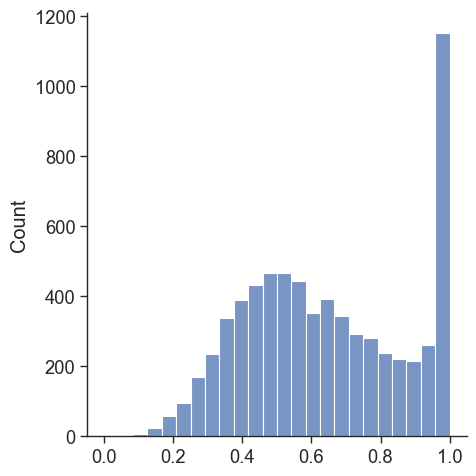

In [41]:
sns.displot(np.sum(weights, axis=1))

In [42]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')

100%|██████████████████████████████████████████| 90/90 [00:00<00:00, 288.60it/s]


In [43]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ad, model.A_, celltype_label='celltype',summarize_layer='raw', minimum_weight=0.05)

100%|███████████████████████████████████████████| 90/90 [01:01<00:00,  1.47it/s]


In [44]:
SEACell_soft_ad.obs

,Pseudo-sizes,celltype,celltype_purity
0,82.343145,HMP,0.969600
1,42.208843,HMP,0.806696
2,115.772085,HMP,0.855165
3,90.552095,DCPre,0.769150
4,62.669747,Ery,0.859173
...,...,...,...
85,163.167671,HSC,0.998878
86,129.512485,HMP,0.955050
87,87.563168,DCPre,0.477902
88,28.836408,cDC,0.887196


In [45]:
SEACell_soft_ad.to_df().tail(10)

,LINC01128,FAM41C,NOC2L,ISG15,AGRN,C1orf159,SDF4,B3GALT6,UBE2J2,SCNN1D,...,MPP1,F8,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,TMLHE
80,0.034166,0.010090,0.198663,0.058965,0.003398,0.139207,0.566213,0.181380,0.235099,0.000000,...,0.161673,0.056787,0.298182,0.000000,0.042905,0.104110,0.273326,0.000000,0.015275,0.320150
81,0.114378,0.040143,0.574430,0.547605,0.039631,0.273320,0.829061,0.290710,0.638061,0.026959,...,0.482645,0.011457,0.727369,0.112917,0.183993,0.302057,0.743872,0.015423,0.079008,0.314765
82,0.348153,0.048238,0.614140,0.172083,0.000000,0.057653,0.629833,0.178752,0.344843,0.000000,...,0.230106,0.000000,0.398547,0.142099,0.010610,0.213122,0.270488,0.056032,0.199511,0.426977
83,0.036345,0.043995,0.403848,0.353290,0.000000,0.104088,0.193857,0.195066,0.263473,0.010392,...,0.345498,0.020451,0.262586,0.097801,0.094625,0.283235,0.373697,0.068914,0.009123,0.124662
84,0.046349,0.000000,0.341022,0.057879,0.000000,0.022543,0.183922,0.020118,0.259529,0.012701,...,0.072767,0.039494,0.236088,0.000000,0.343182,0.120231,0.136768,0.009118,0.015691,0.069844
85,0.044620,0.009874,0.156268,0.088232,0.000000,0.081876,0.204395,0.059749,0.152046,0.011754,...,0.092883,0.008645,0.157720,0.024116,0.072152,0.091545,0.144317,0.013388,0.145716,0.183723
86,0.091326,0.030421,0.274066,0.247463,0.019312,0.150104,0.408921,0.127190,0.284817,0.049288,...,0.257969,0.021267,0.244964,0.054007,0.142052,0.212753,0.283061,0.018680,0.080759,0.216743
87,0.049226,0.019916,0.402623,0.124734,0.034773,0.100925,0.394391,0.138108,0.193353,0.052798,...,0.266866,0.023268,0.253939,0.031413,0.135798,0.317040,0.152398,0.001207,0.079575,0.231503
88,0.242385,0.000000,0.315703,0.230963,0.031320,0.230052,0.483129,0.148026,0.257473,0.000000,...,0.176739,0.000000,0.404884,0.069341,0.151180,0.265892,0.217799,0.000000,0.225828,0.357510
89,0.248353,0.008603,1.218642,0.167646,0.071639,0.311890,1.242991,0.546067,1.541886,0.073702,...,1.456680,0.158951,1.242997,0.158382,0.208006,0.450135,1.241572,0.030095,0.216396,0.339055


In [46]:
SEACell_ad.to_df("raw").head(10)

,LINC01128,FAM41C,NOC2L,ISG15,AGRN,C1orf159,SDF4,B3GALT6,UBE2J2,SCNN1D,...,MPP1,F8,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,TMLHE
SEACell-13,11.0,4.0,30.0,24.0,3.0,14.0,50.0,19.0,23.0,1.0,...,69.0,4.0,48.0,5.0,18.0,37.0,37.0,0.0,7.0,20.0
SEACell-18,3.0,1.0,22.0,9.0,3.0,12.0,10.0,4.0,9.0,1.0,...,8.0,2.0,5.0,4.0,5.0,13.0,9.0,0.0,4.0,9.0
SEACell-39,14.0,4.0,40.0,29.0,1.0,18.0,47.0,16.0,39.0,4.0,...,52.0,3.0,44.0,4.0,20.0,28.0,33.0,2.0,25.0,45.0
SEACell-29,9.0,2.0,25.0,21.0,1.0,6.0,34.0,8.0,14.0,2.0,...,34.0,7.0,38.0,2.0,13.0,19.0,39.0,3.0,23.0,42.0
SEACell-40,6.0,0.0,30.0,14.0,4.0,11.0,25.0,9.0,35.0,3.0,...,64.0,1.0,31.0,3.0,6.0,12.0,44.0,2.0,8.0,17.0
SEACell-30,9.0,3.0,35.0,22.0,1.0,19.0,47.0,25.0,33.0,2.0,...,27.0,2.0,38.0,2.0,22.0,26.0,36.0,1.0,23.0,43.0
SEACell-79,10.0,0.0,21.0,15.0,1.0,8.0,22.0,12.0,16.0,3.0,...,41.0,1.0,23.0,2.0,9.0,14.0,22.0,2.0,6.0,7.0
SEACell-26,9.0,1.0,29.0,14.0,1.0,18.0,34.0,21.0,35.0,0.0,...,73.0,2.0,39.0,9.0,3.0,14.0,35.0,2.0,4.0,22.0
SEACell-16,8.0,0.0,36.0,14.0,1.0,15.0,47.0,22.0,38.0,0.0,...,47.0,1.0,35.0,4.0,6.0,7.0,52.0,2.0,6.0,12.0
SEACell-20,15.0,6.0,42.0,35.0,2.0,27.0,65.0,21.0,30.0,6.0,...,40.0,7.0,45.0,16.0,30.0,38.0,57.0,3.0,14.0,36.0


In [47]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(SEACell_ad)
sc.pp.log1p(SEACell_ad)

In [48]:
sc.pp.highly_variable_genes(SEACell_ad, n_top_genes=800)

/var/folders/4l/kjyt825d7m97k860b19j1kbm0000gn/T/ipykernel_2739/2662094258.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(SEACell_ad.to_df().var())


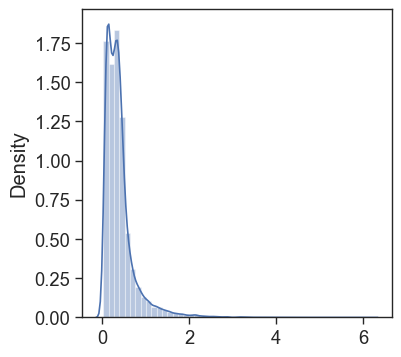

In [49]:
sns.distplot(SEACell_ad.to_df().var())

In [50]:
(SEACell_ad.to_df().var()>1).sum()

705

In [51]:
# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explaint
sc.tl.pca(SEACell_ad, n_comps=10, use_highly_variable=True)

In [52]:
sum(SEACell_ad.uns['pca']['variance_ratio'][:10])

0.8214823880857999

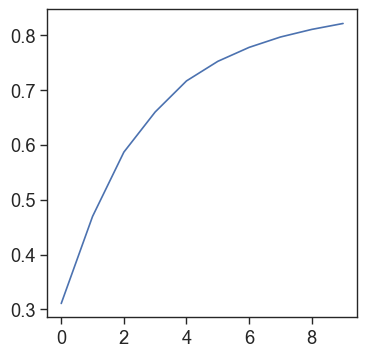

In [53]:
plt.plot(np.cumsum(SEACell_ad.uns['pca']['variance_ratio']))

In [54]:
SEACell_ad.obsm['X_pca'].shape

(90, 10)

In [55]:
SEACell_ad

AnnData object with n_obs × n_vars = 90 × 12464
    obs: 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw'

In [56]:
sc.pp.neighbors(SEACell_ad, n_neighbors=5)

In [57]:
sc.tl.umap(SEACell_ad, n_components=2, min_dist=0.5, spread=1.0)

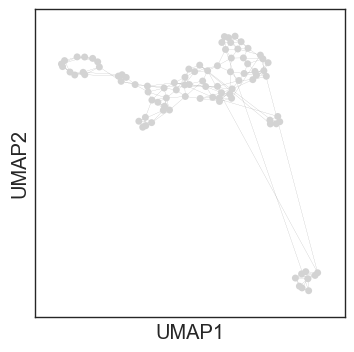

In [58]:
sc.pl.umap(SEACell_ad, edges=True, size=100)

In [59]:
SEACell_ad.obsm['X_umap']

array([[ 6.485356  , 11.051886  ],
       [ 9.130852  , 13.60187   ],
       [ 3.3742375 , 10.89944   ],
       [ 3.40184   ,  9.21167   ],
       [-2.4248962 , 13.441014  ],
       [ 3.3299463 ,  8.833688  ],
       [ 2.442851  , 10.531367  ],
       [-2.1046395 , 12.378136  ],
       [-1.6917123 , 13.786821  ],
       [ 4.6110272 , 10.112565  ],
       [ 6.8888326 , 15.6712475 ],
       [ 2.3076556 ,  7.4028487 ],
       [-0.39589897, 12.84867   ],
       [ 9.911445  ,  7.577642  ],
       [ 4.5924406 , 11.894978  ],
       [ 9.188588  , 12.501396  ],
       [-1.3411944 , 12.353469  ],
       [ 3.972215  , 11.388683  ],
       [ 3.0135245 ,  9.575318  ],
       [11.629342  , -6.1398993 ],
       [-2.6041646 , 13.128764  ],
       [ 2.1305604 ,  7.2588253 ],
       [ 1.6873102 , 11.215933  ],
       [ 8.753941  , 12.087717  ],
       [ 2.6648672 ,  9.777817  ],
       [ 2.6491327 ,  7.686017  ],
       [ 7.2906885 , 13.676925  ],
       [ 6.6035557 ,  9.651344  ],
       [ 6.2094026 ,

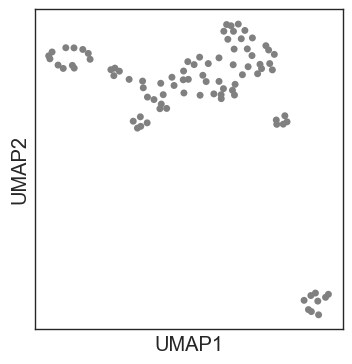

In [60]:
sc.pl.scatter(SEACell_ad, basis='umap', size=100)

In [61]:
SEACell_ad.to_df()

,LINC01128,FAM41C,NOC2L,ISG15,AGRN,C1orf159,SDF4,B3GALT6,UBE2J2,SCNN1D,...,MPP1,F8,FUNDC2,CMC4,MTCP1,BRCC3,VBP1,RAB39B,CLIC2,TMLHE
SEACell-13,1.943113,1.155215,2.851302,2.642497,0.967375,2.153096,3.338749,2.427442,2.603028,0.434167,...,3.651014,1.155215,3.299404,1.313289,2.378266,3.050033,3.050033,0.000000,1.569810,2.474312
SEACell-18,1.539178,0.797621,3.326673,2.483428,1.539178,2.750025,2.580408,1.771729,2.483428,0.797621,...,2.376023,1.235618,1.960273,1.771729,1.960273,2.825139,2.483428,0.000000,1.771729,2.483428
SEACell-39,1.976237,1.020964,2.931657,2.630093,0.367394,2.196270,3.084954,2.092293,2.907706,1.020964,...,3.181643,0.846684,3.022110,1.020964,2.290446,2.597572,2.750530,0.635483,2.493138,3.043500
SEACell-29,1.910975,0.824144,2.833160,2.669949,0.494674,1.576870,3.124950,1.811515,2.298526,0.824144,...,3.124950,1.701059,3.231540,0.824144,2.232112,2.577130,3.256502,1.071546,2.754881,3.327855
SEACell-40,1.901447,0.000000,3.383640,2.659537,1.568001,2.437281,3.208080,2.255846,3.532933,1.347498,...,4.123140,0.667451,3.415335,1.347498,1.901447,2.516983,3.755780,1.064202,2.151076,2.841267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEACell-82,3.041706,1.168032,3.466337,2.288754,0.000000,1.692182,3.654966,2.288754,2.803943,0.000000,...,2.034310,0.000000,3.041706,2.034310,0.000000,2.491410,2.929874,1.168032,2.491410,2.929874
SEACell-58,0.000000,0.000000,1.877222,1.877222,0.000000,1.877222,3.532575,2.868238,2.868238,0.000000,...,2.868238,0.000000,3.141619,0.000000,2.868238,1.877222,3.141619,0.000000,2.868238,3.141619
SEACell-84,2.063072,0.000000,3.742909,0.000000,0.000000,0.000000,3.349217,0.000000,3.349217,0.000000,...,2.063072,0.000000,3.349217,0.000000,3.893671,2.690580,2.690580,0.000000,0.000000,2.063072
SEACell-21,1.602487,0.000000,3.036242,3.210529,0.000000,2.189498,3.210529,2.556925,3.036242,0.000000,...,0.000000,0.000000,3.210529,1.602487,1.602487,2.189498,2.189498,1.602487,1.602487,3.036242


In [62]:
SEACell_ad.obs_names

Index(['SEACell-13', 'SEACell-18', 'SEACell-39', 'SEACell-29', 'SEACell-40',
       'SEACell-30', 'SEACell-79', 'SEACell-26', 'SEACell-16', 'SEACell-20',
       'SEACell-42', 'SEACell-41', 'SEACell-4', 'SEACell-48', 'SEACell-28',
       'SEACell-6', 'SEACell-22', 'SEACell-2', 'SEACell-75', 'SEACell-27',
       'SEACell-14', 'SEACell-11', 'SEACell-10', 'SEACell-54', 'SEACell-49',
       'SEACell-85', 'SEACell-71', 'SEACell-81', 'SEACell-55', 'SEACell-53',
       'SEACell-3', 'SEACell-57', 'SEACell-38', 'SEACell-44', 'SEACell-45',
       'SEACell-32', 'SEACell-47', 'SEACell-65', 'SEACell-17', 'SEACell-37',
       'SEACell-87', 'SEACell-12', 'SEACell-60', 'SEACell-33', 'SEACell-52',
       'SEACell-73', 'SEACell-56', 'SEACell-62', 'SEACell-86', 'SEACell-66',
       'SEACell-64', 'SEACell-51', 'SEACell-76', 'SEACell-61', 'SEACell-31',
       'SEACell-59', 'SEACell-69', 'SEACell-72', 'SEACell-88', 'SEACell-63',
       'SEACell-9', 'SEACell-46', 'SEACell-8', 'SEACell-0', 'SEACell-77',
      

In [63]:
df = pd.DataFrame(SEACell_ad.obsp["connectivities"].toarray())
df.index = SEACell_ad.obs_names
df

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
SEACell-13,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
SEACell-18,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
SEACell-39,0.0,0.0,0.0,0.0,0.0,0.0,0.216888,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
SEACell-29,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
SEACell-40,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.129058,0.87245,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEACell-82,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.204767,0.0,0.0,0.0
SEACell-58,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,...,0.655842,0.0,0.0,0.0,0.000000,0.204767,0.000000,0.0,0.0,0.0
SEACell-84,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,...,0.162606,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0
SEACell-21,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0,...,0.000000,0.0,0.0,0.0,0.277348,0.000000,0.000000,1.0,0.0,0.0


In [64]:
#print(SEACell_ad.obsp["distances"].toarray()[0])

In [65]:
print(SEACell_ad.obsp["connectivities"].toarray()[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.34965855
 0.         0.         0.         0.         0.5077848  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.46448517 0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


In [66]:
adjacency_matrix = (SEACell_ad.obsp["connectivities"].toarray()!=0).astype(int)

In [67]:
adjacency_list = []
for i in range(0,90):
    ind = np.arange(0, 90)
    adjacency_list.append(ind[adjacency_matrix[i] == 1])

In [68]:
count1 = 0
count2 = 0
threshold = 0.05
weights_by_cell = []
for i in range(model.A_.shape[1]):
    if(max(model.A_[:,i]) == 1):
        count2 += 1
    no = len(model.A_[:,i][model.A_[:,i]> threshold])
    if(no < 3):
        count1 +=1
        continue
    ind = np.argsort(model.A_[:,i])[::-1][:no]
    ind2 = []
    for j in range(len(ind)):
        ind2.append("{}{}".format("SEACell-", ind[j]))
    weights_by_cell.append(ind2)
print(count1 - count2)
print(count2)
print(count1)
#print(weights_by_cell)

2845
361
3206


In [69]:
triangles = []
in_triangles = set()
data = [set() for x in range(90)]
for s in range(90):
    for t in adjacency_list[s]:
        if(s < t):
            for v in data[s].intersection(data[t]):
                triangles.append((v,s,t))
                in_triangles.add(v)
                in_triangles.add(s)
                in_triangles.add(t)
            data[t].add(s)
print(len(triangles))
print(len(in_triangles))
all = set(range(90))
print(all.difference(in_triangles))
#print(triangles)

160
90
set()


In [70]:
nn_triangles = []
names = SEACell_ad.obs_names
for i in triangles:
    nn_triangles.append((names[i[0]], names[i[1]], names[i[2]]))
print(nn_triangles)

[('SEACell-29', 'SEACell-30', 'SEACell-75'), ('SEACell-29', 'SEACell-30', 'SEACell-56'), ('SEACell-29', 'SEACell-30', 'SEACell-62'), ('SEACell-39', 'SEACell-79', 'SEACell-49'), ('SEACell-39', 'SEACell-79', 'SEACell-53'), ('SEACell-39', 'SEACell-79', 'SEACell-62'), ('SEACell-40', 'SEACell-26', 'SEACell-14'), ('SEACell-40', 'SEACell-26', 'SEACell-89'), ('SEACell-40', 'SEACell-16', 'SEACell-14'), ('SEACell-18', 'SEACell-6', 'SEACell-32'), ('SEACell-26', 'SEACell-22', 'SEACell-12'), ('SEACell-4', 'SEACell-22', 'SEACell-59'), ('SEACell-26', 'SEACell-22', 'SEACell-59'), ('SEACell-39', 'SEACell-2', 'SEACell-53'), ('SEACell-39', 'SEACell-2', 'SEACell-44'), ('SEACell-28', 'SEACell-2', 'SEACell-44'), ('SEACell-28', 'SEACell-2', 'SEACell-86'), ('SEACell-28', 'SEACell-2', 'SEACell-31'), ('SEACell-29', 'SEACell-75', 'SEACell-49'), ('SEACell-29', 'SEACell-75', 'SEACell-62'), ('SEACell-30', 'SEACell-75', 'SEACell-62'), ('SEACell-16', 'SEACell-14', 'SEACell-52'), ('SEACell-40', 'SEACell-14', 'SEACell-

In [71]:
counts = np.array([0] * len(nn_triangles))
confirmed_triangles = []
for index, triangle in enumerate(nn_triangles):
    for weights in weights_by_cell:
        if(len(set(triangle).difference(set(weights))) == 0):
            counts[index] += 1
    if(counts[index] > 3):
        confirmed_triangles.append(triangle)
#print(counts[counts > 0])
print(counts)
print(confirmed_triangles)

[24 45 21 18 13 15  0  0 10  8  8 16 11 19 32 30 28 17  1 13 23 18  4  7
 62 20 45 19 17 24 27  8 15  3 15 45 25 49 32 17 12 17 29  3  8 22 27  0
  1 13  2  5  6  9 31 23 42 18  2  5  5 11 14  5  3  7 11 19 10 19  6 10
  7  7  6  1  9  1  1 10 10 21 24 16 19 26 10 11 24 30  4  4 20 23 17  1
 10  8 10  4  8 14 27 14  9  8 11 13  1  6  3  3  6  6  2  2  6  2  3  1
  7  2  8  9  3  1  2  2  3  5  3  3  8  2  3 13  7  6  0  5  5  0  1 12
  5  8  1  9  9  2 13  2  1  4  8  4  1  1 13  0]
[('SEACell-29', 'SEACell-30', 'SEACell-75'), ('SEACell-29', 'SEACell-30', 'SEACell-56'), ('SEACell-29', 'SEACell-30', 'SEACell-62'), ('SEACell-39', 'SEACell-79', 'SEACell-49'), ('SEACell-39', 'SEACell-79', 'SEACell-53'), ('SEACell-39', 'SEACell-79', 'SEACell-62'), ('SEACell-40', 'SEACell-16', 'SEACell-14'), ('SEACell-18', 'SEACell-6', 'SEACell-32'), ('SEACell-26', 'SEACell-22', 'SEACell-12'), ('SEACell-4', 'SEACell-22', 'SEACell-59'), ('SEACell-26', 'SEACell-22', 'SEACell-59'), ('SEACell-39', 'SEACell-2', '

In [72]:
print("Number of confirmed triangles is: " + str(len(confirmed_triangles)))
print("Number of removed triangles after comparing to weight assignments for each cell is: " + str(len(nn_triangles) - len(confirmed_triangles)))
all = set()
for i in range(90):
    all.add("{}{}".format("SEACell-", i))
confirmed_set = set()
for triangle in confirmed_triangles:
    confirmed_set.update(triangle)
print("Number of SEACells that do not exist in the remaining triangles is: " + str(len(all.difference(confirmed_set))))
print("It is this set:")
print(all.difference(confirmed_set))

Number of confirmed triangles is: 118
Number of removed triangles after comparing to weight assignments for each cell is: 42
Number of SEACells that do not exist in the remaining triangles is: 2
It is this set:
{'SEACell-36', 'SEACell-13'}


In [73]:
power = np.linalg.matrix_power(adjacency_matrix, 2)
print(np.trace(power))
power = np.linalg.matrix_power(adjacency_matrix, 3)
print(np.trace(power)/6)
power = np.linalg.matrix_power(adjacency_matrix, 4)
sum_degree_squared = np.sum(np.power(np.sum(adjacency_matrix, axis = 0), 2))
sum_degree = np.sum(np.sum(adjacency_matrix, axis = 0))
print((np.trace(power) - 2*sum_degree_squared + sum_degree)/8)

466
160.0
295.0
